In [76]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display, HTML

from matplotlib.patches import FancyArrowPatch
from scipy.optimize import minimize

In [77]:
current_dir = os.getcwd()
# Поднимаемся от текущей директории до spores/v14_back/src
project_root = os.path.abspath(os.path.join(current_dir, '..', '..', '..', 'src'))
if project_root not in sys.path:
    sys.path.append(project_root)

from logic.pendulum import PendulumSystem
from logic.control_tree import ControlTreeBuilder

# Настройка matplotlib для Jupyter
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['figure.dpi'] = 100

print("✅ Модули загружены")

✅ Модули загружены


In [78]:
def sort_grandchildren_simple(grandchildren, root_position, show: bool = False):
    """
    Простая сортировка внуков: фиксированное направление + roll по условию.
    
    Args:
        grandchildren: список внуков с данными позиций и родителей
        root_position: позиция корневой споры для расчета углов
    
    Returns:
        отсортированный список внуков
    """
    
    def get_angle_from_root(gc):
        """Вычисляет угол от корня до внука."""
        dx = gc['position'][0] - root_position[0]
        dy = gc['position'][1] - root_position[1] 
        return np.arctan2(dy, dx)
    
    # 1. Сортируем по углу (против часовой стрелки)
    sorted_gc = sorted(grandchildren, key=get_angle_from_root, reverse=True)
    
    if show:
        print("🔍 Углы внуков после первичной сортировки:")
    for i, gc in enumerate(sorted_gc):
        angle_deg = get_angle_from_root(gc) * 180 / np.pi
        if show:    
            print(f"  {i}: {gc['name']} (родитель {gc['parent_idx']}) под углом {angle_deg:.1f}°")
    
    # 2. Находим первого внука от родителя 0
    roll_offset = 0
    for i, gc in enumerate(sorted_gc):
        if gc['parent_idx'] == 0:
            roll_offset = i
            if show:
                print(f"🎯 Найден внук родителя 0 на позиции {i}, roll_offset = {roll_offset}")
            break
    
    # 3. Делаем roll чтобы внук родителя 0 стал первым
    sorted_gc = np.roll(sorted_gc, -roll_offset).tolist()
    if show:
        print(f"🔄 Применен roll на {-roll_offset}")
    
    # 4. Проверяем критерий: 1-й внук от другого родителя?
    if len(sorted_gc) >= 2 and sorted_gc[1]['parent_idx'] == 0:
        # Если 1-й тоже от родителя 0, сдвигаем на 1
        sorted_gc = np.roll(sorted_gc, 1).tolist()
        if show:
            print("🔄 Применен дополнительный roll +1")
    
    if show:
        print(f"\n✅ Итоговый обход:")
        print(f"   0-й внук от родителя {sorted_gc[0]['parent_idx']} ({sorted_gc[0]['name']})")
        print(f"   1-й внук от родителя {sorted_gc[1]['parent_idx']} ({sorted_gc[1]['name']})")
    
    return sorted_gc

In [79]:
def build_simple_tree(initial_position, dt_value, pendulum, dt_children=None, dt_grandchildren=None, show: bool = False):
    """
    Строит простое дерево спор глубиной 2 с поддержкой индивидуальных dt.
    
    Args:
        initial_position: np.array([theta, theta_dot]) - начальная позиция
        dt_value: float - стандартный временной шаг (используется если dt_children=None)
        pendulum: объект маятника для расчетов
        dt_children: список из 4 значений dt для детей [forward_max, backward_max, forward_min, backward_min]
                    Если None, используется dt_value для всех детей
        dt_grandchildren: список из 8 значений dt для внуков [gc_0_0, gc_0_1, gc_1_0, gc_1_1, ...]
                         Если None, вычисляется как dt_parent / k для каждого внука
        show: bool - выводить отладочную информацию
    
    Returns:
        dict с корневой спорой, детьми и внуками
    """
    if show:
        print(f"🌱 Строим дерево из позиции {initial_position}")
        if dt_children is not None:
            print(f"📊 Используем индивидуальные dt детей: {dt_children}")
        else:
            print(f"📊 Используем стандартный dt={dt_value} для всех детей")
        
        if dt_grandchildren is not None:
            print(f"👶 Используем индивидуальные dt внуков: {dt_grandchildren}")
        else:
            print(f"👶 dt внуков будет вычисляться автоматически (dt_parent / k)")
    
    # Получаем границы управления
    u_min, u_max = pendulum.get_control_bounds()
    
    # Корневая спора
    root = {
        'position': initial_position.copy(),
        'id': 'root',
        'color': 'red',
        'size': 100
    }
    
    # Настройка dt для каждого ребенка
    if dt_children is None:
        # Стандартный режим - все дети используют один dt
        dt_list = [dt_value, dt_value, dt_value, dt_value]
    else:
        # Индивидуальные dt для каждого ребенка
        assert len(dt_children) == 4, "dt_children должен содержать ровно 4 элемента"
        dt_list = dt_children.copy()
    
    # 4 потомка с индивидуальными dt
    children = []
    configs = [
        {'control': u_max, 'dt_sign': 1, 'name': 'forward_max', 'color': 'blue', 'dt_idx': 0},
        {'control': u_max, 'dt_sign': -1, 'name': 'backward_max', 'color': 'cyan', 'dt_idx': 1}, 
        {'control': u_min, 'dt_sign': 1, 'name': 'forward_min', 'color': 'green', 'dt_idx': 2},
        {'control': u_min, 'dt_sign': -1, 'name': 'backward_min', 'color': 'orange', 'dt_idx': 3}
    ]
    
    for i, config in enumerate(configs):
        # Используем индивидуальный dt для этого ребенка
        child_dt = dt_list[config['dt_idx']] * config['dt_sign']
        
        # Вычисляем новую позицию
        new_pos = pendulum.scipy_rk45_step(initial_position, config['control'], child_dt)
            
        child = {
            'position': new_pos,
            'id': f"child_{i}",
            'name': config['name'],
            'color': config['color'],
            'size': 60,
            'control': config['control'],
            'dt': child_dt,
            'dt_abs': abs(child_dt),  # Абсолютное значение dt для внуков
            'dt_idx': config['dt_idx']  # Индекс в dt_list
        }
        children.append(child)
        
        if show:
            print(f"  🍄 {config['name']}: u={config['control']:+.1f}, dt={child_dt:+.3f} → {new_pos}")
    
    # Сортируем детей по углу относительно корня
    def get_angle(child):
        dx = child['position'][0] - root['position'][0] 
        dy = child['position'][1] - root['position'][1]
        return np.arctan2(dy, dx)
    
    children_sorted = sorted(children, key=get_angle)
    
    # Переназначаем ID по порядку
    for i, child in enumerate(children_sorted):
        child['id'] = f"child_{i}"
    
    if show:
        print("\n🔄 После сортировки по углу:")
        for i, child in enumerate(children_sorted):
            angle = get_angle(child) * 180 / np.pi
            print(f"  {i}: {child['name']} под углом {angle:.1f}°, dt={child['dt']:+.3f}")

    # Строим внуков (уровень 2)
    grandchildren = []
    if show:
        print("\n🌳 Строим уровень 2 (обращенное управление):")

    k = 2  # Коэффициент уменьшения dt для внуков (используется только если dt_grandchildren=None)

    for parent_idx, parent in enumerate(children_sorted):
        # Обращаем знак управления родителя
        reversed_control = -parent['control']
        
        if show:
            print(f"\n  👶 От споры {parent_idx} (u={parent['control']:+.1f}, dt={parent['dt']:+.3f}):")
            print(f"      Строим детей с u={reversed_control:+.1f}")
        
        # 2 потомка с обращенным управлением: +dt и -dt
        grandchild_configs = [
            {'dt_sign': 1, 'name': f'gc_{parent_idx}_forward', 'color': 'lightblue'},
            {'dt_sign': -1, 'name': f'gc_{parent_idx}_backward', 'color': 'lightcoral'}
        ]
        
        for gc_idx, gc_config in enumerate(grandchild_configs):
            # Вычисляем глобальный индекс внука для dt_grandchildren
            gc_global_idx = parent_idx * 2 + gc_idx
            
            # Определяем dt для этого внука
            if dt_grandchildren is not None:
                # Используем индивидуальный dt из массива
                assert len(dt_grandchildren) == 8, "dt_grandchildren должен содержать ровно 8 элементов"
                gc_dt_abs = dt_grandchildren[gc_global_idx]
            else:
                # Автоматическое вычисление: dt родителя / k
                gc_dt_abs = parent['dt_abs'] / k
            
            # Применяем знак направления
            final_dt = gc_dt_abs * gc_config['dt_sign']
            
            new_pos = pendulum.scipy_rk45_step(parent['position'], reversed_control, final_dt)
            
            grandchild = {
                'position': new_pos,
                'parent_id': parent['id'],
                'parent_idx': parent_idx,
                'local_idx': gc_idx,
                'global_idx': gc_global_idx,  # Будет переназначен после сортировки
                'id': f"gc_{parent_idx}_{gc_idx}",
                'name': gc_config['name'],
                'color': gc_config['color'],
                'size': 40,
                'control': reversed_control,
                'dt': final_dt,
                'dt_abs': gc_dt_abs,
                'parent_dt': parent['dt']  # Сохраняем dt родителя для отладки
            }
            grandchildren.append(grandchild)
            
            if show:
                direction = "вперед" if gc_config['dt_sign'] > 0 else "назад"
                dt_source = f"индивидуальный[{gc_global_idx}]" if dt_grandchildren is not None else f"авто (родитель/k)"
                print(f"    🌱 {gc_idx}: u={reversed_control:+.1f}, dt={final_dt:+.4f} ({direction}, {dt_source}) → {new_pos}")

    grandchildren_sorted = sort_grandchildren_simple(grandchildren, root['position'])
    
    # Переназначаем глобальные индексы
    for i, gc in enumerate(grandchildren_sorted):
        gc['global_idx'] = i
    
    if show:
        print("\n🔄 Итоговый порядок внуков:")
        for i, gc in enumerate(grandchildren_sorted):
            print(f"  {i}: родитель {gc['parent_idx']}, u={gc['control']:+.1f}, dt={gc['dt']:+.4f}")
        
    return {
        'root': root,
        'children': children_sorted,
        'grandchildren': grandchildren_sorted,
        'dt_info': {
            'dt_children': dt_list,
            'dt_grandchildren': dt_grandchildren if dt_grandchildren is not None else 'auto',
            'dt_standard': dt_value,
            'k_factor': k
        }
    }

In [80]:
def visualize_tree(tree_data):
    """
    Визуализирует дерево спор с траекториями и стрелочками.
    Показывает индивидуальные dt для каждого ребенка.
    
    Args:
        tree_data: словарь с данными дерева от build_simple_tree
    """
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    root = tree_data['root']
    children = tree_data['children']
    dt_info = tree_data.get('dt_info', {})
    
    # Рисуем корневую спору
    ax.scatter(root['position'][0], root['position'][1], 
              c=root['color'], s=root['size'], alpha=0.8, 
              label='Root', edgecolors='black', linewidth=2)
    
    # Рисуем детей и стрелочки от корня к детям
    for i, child in enumerate(children):
        # Номер рядом с точкой
        percent = 0.0001 * 0
        ax.text(child['position'][0] * (1 + percent), child['position'][1] * (1 + percent), 
            str(i), fontsize=12, fontweight='bold', 
            color='black', ha='left', va='bottom',
            bbox=dict(boxstyle="circle,pad=0.1", facecolor='white', alpha=0.8))
        
        # Точка-потомок
        ax.scatter(child['position'][0], child['position'][1],
                  c=child['color'], s=child['size'], alpha=0.7,
                  label=child['name'], edgecolors='black')
        
        # Стрелочка от корня к потомку
        arrow = FancyArrowPatch(
            (root['position'][0], root['position'][1]),
            (child['position'][0], child['position'][1]),
            arrowstyle='->', 
            mutation_scale=15,
            color=child['color'],
            alpha=0.6,
            linewidth=2
        )
        ax.add_patch(arrow)
        
        # Аннотация с параметрами (показываем индивидуальный dt)
        mid_x = (root['position'][0] + child['position'][0]) / 2
        mid_y = (root['position'][1] + child['position'][1]) / 2
        
        label_text = f"u={child['control']:+.1f}\ndt={child['dt']:+.3f}"
        ax.annotate(label_text, (mid_x, mid_y), 
                   fontsize=8, ha='center', va='center',
                   bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.7))
    
    # Рисуем внуков если они есть
    if 'grandchildren' in tree_data:
        for grandchild in tree_data['grandchildren']:
            # Точка-внук
            ax.scatter(grandchild['position'][0], grandchild['position'][1],
                    c=grandchild['color'], s=grandchild['size'], alpha=0.6,
                    edgecolors='gray', linewidth=1)
            
            # Стрелочка от родителя к внуку
            parent = children[grandchild['parent_idx']]
            arrow = FancyArrowPatch(
                (parent['position'][0], parent['position'][1]),
                (grandchild['position'][0], grandchild['position'][1]),
                arrowstyle='->', 
                mutation_scale=10,
                color=grandchild['color'],
                alpha=0.5,
                linewidth=1.5
            )
            ax.add_patch(arrow)
            
            # Глобальный индекс внука
            label = str(grandchild.get('global_idx', '?'))
            ax.text(grandchild['position'][0], grandchild['position'][1], 
                   label, fontsize=10, fontweight='bold', 
                   color='white', ha='center', va='center',
                   bbox=dict(boxstyle="circle,pad=0.15", facecolor='purple', alpha=0.8))
    
    # Настройки графика
    ax.set_xlabel('θ (радианы)', fontsize=12)
    ax.set_ylabel('θ̇ (рад/с)', fontsize=12)
    
    # Формируем заголовок с информацией о dt
    title = "Дерево спор глубиной 2"
    if dt_info:
        if 'dt_children' in dt_info and dt_info['dt_children'] is not None:
            # Показываем индивидуальные dt детей
            dt_children = dt_info['dt_children']
            title += f"\nДети dt: [{dt_children[0]:.3f}, {dt_children[1]:.3f}, {dt_children[2]:.3f}, {dt_children[3]:.3f}]"
        else:
            # Показываем стандартный dt
            title += f"\nСтандартный dt = {dt_info.get('dt_standard', 'N/A')}"
        
        # Добавляем информацию о dt внуков
        if 'dt_grandchildren' in dt_info:
            dt_gc = dt_info['dt_grandchildren']
            if isinstance(dt_gc, str) and dt_gc == 'auto':
                title += f"\nВнуки dt: автоматические (k={dt_info.get('k_factor', 2)})"
            elif dt_gc is not None:
                title += f"\nВнуки dt: индивидуальные ({len(dt_gc)} значений)"
            else:
                title += f"\nВнуки dt: автоматические (k={dt_info.get('k_factor', 2)})"
    
    ax.set_title(title, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Выводим сводку в консоль
    print(f"\n📊 СВОДКА ДЕРЕВА:")
    print(f"   🌳 Корень: {root['position']}")
    print(f"   🍄 Детей: {len(children)} спор")
    if 'grandchildren' in tree_data:
        print(f"   👶 Внуков: {len(tree_data['grandchildren'])} спор")
    if dt_info:
        print(f"   ⏱️  dt детей: {dt_info.get('dt_children', 'стандартный')}")
        dt_gc = dt_info.get('dt_grandchildren', 'auto')
        if isinstance(dt_gc, str) and dt_gc == 'auto':
            print(f"   👶 dt внуков: автоматические (k={dt_info.get('k_factor', 2)})")
        elif dt_gc is not None:
            print(f"   👶 dt внуков: индивидуальные {[f'{dt:.3f}' for dt in dt_gc]}")
        else:
            print(f"   👶 dt внуков: автоматические (k={dt_info.get('k_factor', 2)})")

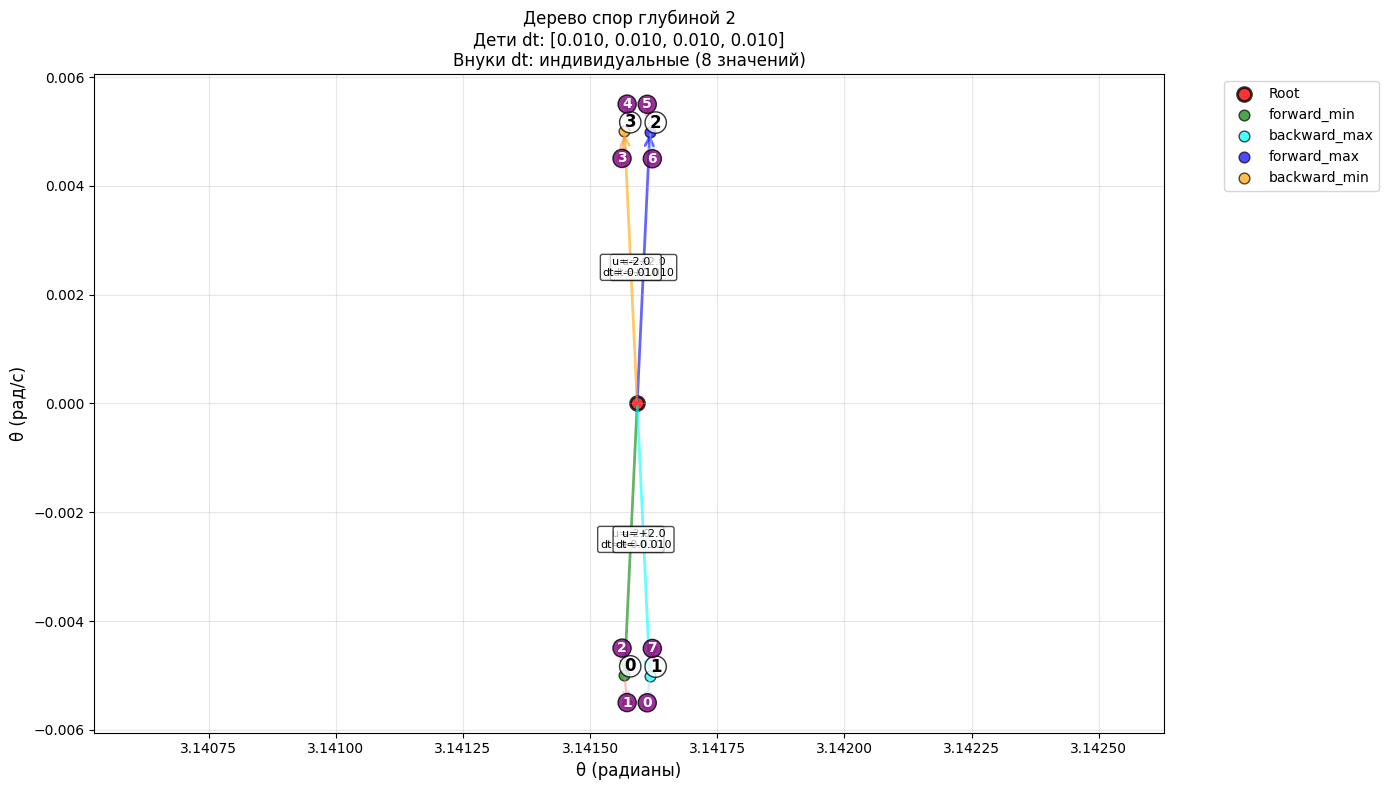


📊 СВОДКА ДЕРЕВА:
   🌳 Корень: [3.14159265 0.        ]
   🍄 Детей: 4 спор
   👶 Внуков: 8 спор
   ⏱️  dt детей: [0.01 0.01 0.01 0.01]
   👶 dt внуков: индивидуальные ['0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001', '0.001']


In [81]:

dt = 0.01  # Временной шаг - можно менять!

# Создаем систему маятника (используем из проекта)
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

initial_pos = np.array([np.pi, 0.0])

# Строим дерево
tree = build_simple_tree(initial_pos, dt, pendulum, 
                         dt_children=np.ones(4)*dt,
                         dt_grandchildren=np.ones(8)*dt/10
)

# Визуализируем  
visualize_tree(tree)

# print(f"\n📊 Статистика:")
# print(f"Корневая спора: {tree['root']['position']}")
# print(f"Количество потомков: {len(tree['children'])}")
# for child in tree['children']:
#     distance = np.linalg.norm(child['position'] - tree['root']['position'])
#     print(f"  {child['name']}: расстояние от корня = {distance:.3f}")

In [82]:
def calc_pair_distances(grandchildren, show=True):
    """
    Вычисляет расстояния между парами внуков.
    Пары: (0,1), (2,3), (4,5), (6,7) по прямому индексу в отсортированном списке.
    
    Args:
        grandchildren: список внуков после сортировки (порядок уже правильный)
        show: выводить отладочную информацию
        
    Returns:
        np.array из 4 расстояний между парами
    """
    distances = np.zeros(4)
    
    for pair_idx in range(4):
        # Прямые индексы пары: (0,1), (2,3), (4,5), (6,7)
        idx1 = pair_idx * 2
        idx2 = pair_idx * 2 + 1
        
        if idx1 < len(grandchildren) and idx2 < len(grandchildren):
            # Берем внуков напрямую по индексу
            gc1 = grandchildren[idx1]
            gc2 = grandchildren[idx2]
            
            # Вычисляем расстояние между позициями
            pos1 = gc1['position']
            pos2 = gc2['position']
            distance = np.linalg.norm(pos1 - pos2)
            distances[pair_idx] = distance
        else:
            if show:
                print(f"⚠️ Недостаточно внуков для пары {pair_idx}: нужны индексы {idx1}, {idx2}")
            distances[pair_idx] = float('inf')
    
    return distances

In [83]:
def calculate_mean_points(grandchildren, show=True):
    """
    Вычисляет средние точки для каждой пары внуков.
    Пары: (0,1), (2,3), (4,5), (6,7) по прямому индексу в отсортированном списке.
    
    Args:
        grandchildren: список внуков после сортировки (порядок уже правильный)
        show: выводить отладочную информацию
        
    Returns:
        np.array размера (4, 2) со средними точками 4 пар
    """
    means = np.zeros((4, 2))
    
    for pair_idx in range(4):
        # Прямые индексы пары: (0,1), (2,3), (4,5), (6,7)
        idx1 = pair_idx * 2
        idx2 = pair_idx * 2 + 1
        
        if idx1 < len(grandchildren) and idx2 < len(grandchildren):
            # Берем внуков напрямую по индексу
            gc1 = grandchildren[idx1]
            gc2 = grandchildren[idx2]
            
            # Вычисляем среднюю точку
            pos1 = gc1['position']
            pos2 = gc2['position']
            means[pair_idx] = (pos1 + pos2) / 2
        else:
            if show:
                print(f"⚠️ Недостаточно внуков для пары {pair_idx}: нужны индексы {idx1}, {idx2}")
            means[pair_idx] = np.array([0, 0])
    
    return means

In [84]:
def calculate_area(mean_points):
    """
    Вычисляет площадь четырехугольника по 4 точкам, используя формулу Шнура.
    
    Args:
        mean_points: np.array размера (4, 2) с координатами 4 вершин
        
    Returns:
        float: площадь четырехугольника
    """
    # Извлекаем координаты
    x = [p[0] for p in mean_points]
    y = [p[1] for p in mean_points]
    
    # Формула Шнура (shoelace formula)
    # Площадь = 0.5 * |Σ(x_i * y_{i+1} - y_i * x_{i+1})|
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    
    return area

In [ ]:
def objective_function(dt_all, initial_position, dt_value, pendulum, show=False):
    """
    Целевая функция для оптимизации - максимизирует площадь четырехугольника.
    
    Args:
        dt_all: np.array из 12 значений dt [4 для детей + 8 для внуков]
        initial_position: начальная позиция
        dt_value: стандартный dt (не используется, оставлен для совместимости)
        pendulum: объект маятника
        show: выводить отладочную информацию
        
    Returns:
        float: отрицательная площадь (для минимизации = максимизации площади)
    """
    try:
        # Разделяем dt на детей и внуков
        dt_children = dt_all[0:4]      # Первые 4 элемента
        dt_grandchildren = dt_all[4:12]  # Остальные 8 элементов
        
        # Строим дерево с текущими dt
        tree = build_simple_tree(
            initial_position=initial_position,
            dt_value=dt_value, 
            pendulum=pendulum,
            dt_children=dt_children,
            dt_grandchildren=dt_grandchildren,
            show=False
        )
        
        # Получаем внуков
        grandchildren = tree['grandchildren']
        
        # Вычисляем средние точки пар
        mean_points = calculate_mean_points(grandchildren, show=show)
        
        # Вычисляем площадь четырехугольника
        area = calculate_area(mean_points)
        
        # Возвращаем отрицательную площадь (scipy.optimize минимизирует)
        return -area
        
    except Exception as e:
        if show:
            print(f"❌ Ошибка в objective_function: {e}")
        return 1e6  # Большое значение при ошибке

In [86]:
def constraint_function(dt_all, initial_position, dt_value, pendulum, 
                       pair_idx, epsilon, show=False):
    """
    Функция ограничений - гарантирует схождение пары внуков.
    
    Args:
        dt_all: np.array из 12 значений dt [4 для детей + 8 для внуков]
        initial_position: начальная позиция
        dt_value: стандартный dt (не используется, оставлен для совместимости)
        pendulum: объект маятника
        pair_idx: индекс пары (0, 1, 2, 3)
        epsilon: допустимое расстояние между внуками в паре
        show: выводить отладочную информацию
        
    Returns:
        float: epsilon - distance (> 0 означает выполнение ограничения)
    """
    try:
        # Разделяем dt на детей и внуков
        dt_children = dt_all[0:4]      # Первые 4 элемента
        dt_grandchildren = dt_all[4:12]  # Остальные 8 элементов
        
        # Строим дерево с текущими dt
        tree = build_simple_tree(
            initial_position=initial_position,
            dt_value=dt_value, 
            pendulum=pendulum,
            dt_children=dt_children,
            dt_grandchildren=dt_grandchildren,
            show=False
        )
        
        # Получаем внуков
        grandchildren = tree['grandchildren']
        
        # Вычисляем расстояния между парами
        distances = calc_pair_distances(grandchildren, show=show)
        
        # Возвращаем ограничение для указанной пары
        constraint_value = epsilon - distances[pair_idx]
        
        return constraint_value
        
    except Exception as e:
        if show:
            print(f"❌ Ошибка в constraint_function для пары {pair_idx}: {e}")
        return -1e6  # Большое отрицательное значение при ошибке


def create_constraints(initial_position, dt_value, pendulum, epsilon=1e-3, show=True):
    """
    Создает список ограничений для всех 4 пар внуков.
    
    Args:
        initial_position: начальная позиция
        dt_value: стандартный dt (для совместимости)
        pendulum: объект маятника
        epsilon: допустимое расстояние между внуками в паре
        show: выводить отладочную информацию
        
    Returns:
        list: список словарей ограничений для scipy.optimize
    """
    constraints = []
    
    def make_constraint_func(pair_idx):
        """Создает функцию ограничения для конкретной пары."""
        def constraint_func(dt_all):
            return constraint_function(dt_all, initial_position, dt_value, pendulum, pair_idx, epsilon, show=False)
        return constraint_func
    
    for pair_idx in range(4):
        constraint = {
            'type': 'ineq',
            'fun': make_constraint_func(pair_idx)
        }
        constraints.append(constraint)
    
    if show:
        print(f"✅ Создано {len(constraints)} ограничений для пар внуков с epsilon={epsilon}")
    return constraints

In [98]:
def optimize_dt(initial_position, pendulum, dt_base=0.1, 
                epsilon=1e-3, dt_bounds=(0.001, 0.1), show=True):
    """
    Оптимизирует все 12 dt (4 детей + 8 внуков) для максимизации площади четырехугольника
    при условии схождения пар внуков.
    
    Args:
        initial_position: начальная позиция маятника
        pendulum: объект PendulumSystem
        dt_base: базовое значение dt для начального приближения
        epsilon: допустимое расстояние между внуками в паре
        dt_bounds: кортеж (min_dt, max_dt) для ограничений
        show: показывать отладочную информацию и прогресс
        
    Returns:
        dict с результатами оптимизации
    """
    
    if show:
        print(f"🚀 Запуск оптимизации всех 12 dt (4 детей + 8 внуков)")
        print(f"   📍 Начальная позиция: {initial_position}")
        print(f"   ⏱️  Базовый dt: {dt_base}")
        print(f"   🎯 Epsilon: {epsilon}")
        print(f"   📏 Границы dt: {dt_bounds}")
    
    # Начальное приближение для всех 12 dt
    initial_guess = dt_base * np.hstack((np.ones(4), np.ones(8)/10))
    
    # Границы для всех 12 dt
    bounds = [dt_bounds] * 12
    
    # Создаем ограничения для схождения пар
    constraints = create_constraints(initial_position, dt_base, pendulum, epsilon, show=show)
    
    # Счетчик итераций для callback
    iteration_count = [0]
    
    def callback(xk):
        """Callback функция для отслеживания прогресса."""
        if show:
            iteration_count[0] += 1
            if iteration_count[0] % 10 == 0:
                # Разделяем dt
                dt_children = xk[0:4]
                dt_grandchildren = xk[4:12]
                
                # Вычисляем текущие метрики
                tree = build_simple_tree(initial_position, dt_base, pendulum, 
                                       dt_children, dt_grandchildren, show=False)
                distances = calc_pair_distances(tree['grandchildren'], show=False)
                mean_points = calculate_mean_points(tree['grandchildren'], show=False)
                area = calculate_area(mean_points)
                
                print(f"   Итерация {iteration_count[0]:3d}: площадь={area:.6f}, "
                      f"расстояния={[f'{d:.4f}' for d in distances]}")
    
    if show:
        print(f"🎯 Начинаем оптимизацию 12 параметров...")
    
    # Запускаем оптимизацию
    result = minimize(
        fun=lambda dt_all: objective_function(dt_all, initial_position, dt_base, pendulum, show=False),
        x0=initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        callback=callback if show else None,
        options={'maxiter': 1000, 'ftol': 1e-9}
    )
    
    if show:
        print(f"\n✅ Оптимизация завершена!")
        print(f"   🎯 Успех: {result.success}")
        print(f"   📊 Итераций: {result.nit}")
        print(f"   📈 Финальная площадь: {-result.fun:.6f}")
    
    if result.success:
        # Разделяем оптимальные dt
        optimal_dt_children = result.x[0:4]
        optimal_dt_grandchildren = result.x[4:12]
        
        if show:
            print(f"   🍄 Оптимальные dt детей: {[f'{dt:.4f}' for dt in optimal_dt_children]}")
            print(f"   👶 Оптимальные dt внуков: {[f'{dt:.4f}' for dt in optimal_dt_grandchildren]}")
        
        # Строим финальное дерево
        final_tree = build_simple_tree(
            initial_position=initial_position,
            dt_value=dt_base, 
            pendulum=pendulum,
            dt_children=optimal_dt_children,
            dt_grandchildren=optimal_dt_grandchildren,
            show=False
        )
        
        # Проверяем финальные расстояния
        final_distances = calc_pair_distances(final_tree['grandchildren'], show=False)
        if show:
            print(f"   📏 Финальные расстояния пар: {[f'{d:.6f}' for d in final_distances]}")
            print(f"   ✅ Все пары сошлись: {np.all(final_distances <= epsilon)}")
        
        return {
            'success': True,
            'optimal_dt_all': result.x,
            'optimal_dt_children': optimal_dt_children,
            'optimal_dt_grandchildren': optimal_dt_grandchildren,
            'final_area': -result.fun,
            'final_distances': final_distances,
            'tree': final_tree,
            'scipy_result': result
        }
    else:
        if show:
            print(f"   ❌ Причина неудачи: {result.message}")
        return {
            'success': False,
            'message': result.message,
            'scipy_result': result
        }

Площадь: 0.003974


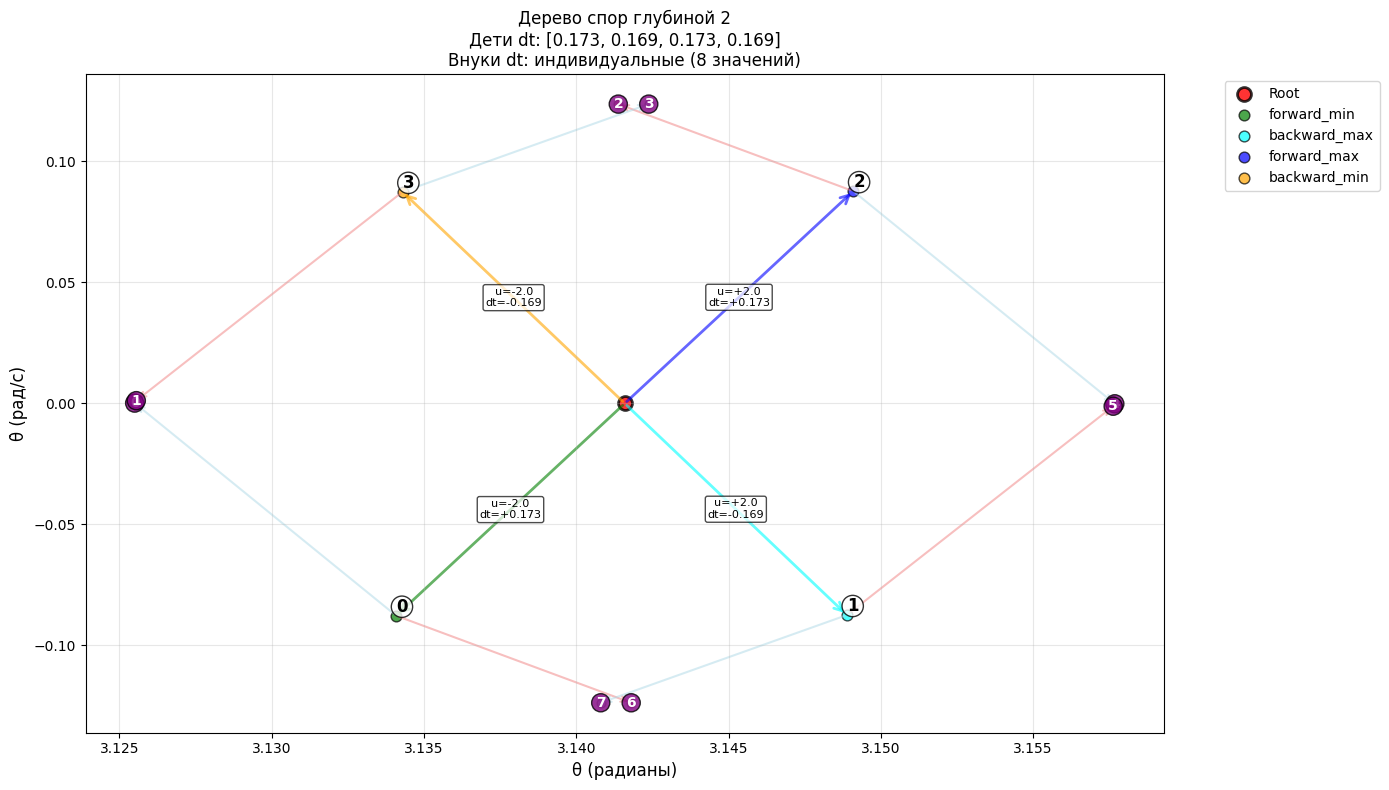


📊 СВОДКА ДЕРЕВА:
   🌳 Корень: [3.14159265 0.        ]
   🍄 Детей: 4 спор
   👶 Внуков: 8 спор
   ⏱️  dt детей: [0.17269656 0.16935946 0.17269563 0.16936036]
   👶 dt внуков: индивидуальные ['0.200', '0.073', '0.077', '0.200', '0.200', '0.073', '0.077', '0.200']


In [100]:
# Тихая оптимизация
result = optimize_dt(
    initial_position=initial_pos, 
    pendulum=pendulum,
    dt_bounds=(0.001, 0.2),
    dt_base=0.1,
    epsilon=1e-3,
    show=False  # Отключить все принты
)

# Только итоговый результат
if result['success']:
    print(f"Площадь: {result['final_area']:.6f}")
    visualize_tree(result['tree'])

In [115]:
result

{'success': False,
 'message': 'Positive directional derivative for linesearch',
 'scipy_result':  message: Positive directional derivative for linesearch
  success: False
   status: 8
      fun: -0.008025564186448397
        x: [ 3.340e-01  1.000e-03  1.000e-03  1.000e-03  1.000e-03
             1.000e-03  1.000e-03  3.340e-01  1.000e-03  3.340e-01
             3.340e-01  1.000e-03]
      nit: 92
      jac: [-2.311e-02  9.569e-03 -9.221e-03 -1.392e-02  2.684e+05
            -3.676e-03 -3.584e-03 -1.313e-02 -8.368e-03 -2.269e-02
            -1.948e-02  2.684e+05]
     nfev: 1401
     njev: 88}

In [121]:
import time

results = []
times = []
time_array = np.linspace(0.001, 5, 20)
for i, dt in enumerate(time_array):
    start_time = time.time()
    result = optimize_dt(
        initial_position=initial_pos, 
        pendulum=pendulum,
        dt_bounds=(0.001, dt),
        dt_base=dt/2,
        epsilon=1e-3,
        show=False  # Отключить все принты
    )
    if result['success']:
        results.append(result)

        print(i, dt.round(4), result['final_area'].round(4))
    else:
        print(i, dt, 'failed')
    print(f"Time taken: {time.time() - start_time:.2f} seconds")
    times.append(time.time() - start_time)

0 0.001 0.0
Time taken: 0.07 seconds
1 0.2641 0.0073
Time taken: 3.56 seconds


C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


2 0.5272 0.0226
Time taken: 15.38 seconds
3 0.7903 0.0333
Time taken: 9.97 seconds
4 1.0534 0.0393
Time taken: 12.95 seconds
5 1.3165 0.0425
Time taken: 27.49 seconds
6 1.5796 0.0443
Time taken: 37.00 seconds
7 1.8427 0.0452
Time taken: 31.59 seconds
8 2.1058421052631577 failed
Time taken: 88.90 seconds
9 2.3689473684210527 failed
Time taken: 47.67 seconds
10 2.632052631578947 failed
Time taken: 22.15 seconds
11 2.8951578947368417 failed
Time taken: 113.72 seconds


KeyboardInterrupt: 

In [ ]:
result = optimize_dt(
    initial_position=np.array([0, 0]), 
    pendulum=pendulum,
    dt_bounds=(0.001, 1),
    dt_base=0.5,
    epsilon=1e-3,
    show=False  # Отключить все принты
    )

In [ ]:
result

{'success': True,
 'optimal_dt_all': array([0.31582446, 0.30257196, 0.31582443, 0.30257199, 1.        ,
        0.12344811, 0.13784649, 1.        , 1.        , 0.12344814,
        0.13784648, 1.        ]),
 'optimal_dt_children': array([0.31582446, 0.30257196, 0.31582443, 0.30257199]),
 'optimal_dt_grandchildren': array([1.        , 0.12344811, 0.13784649, 1.        , 1.        ,
        0.12344814, 0.13784648, 1.        ]),
 'final_area': 0.03833066993535055,
 'final_distances': array([0.001, 0.001, 0.001, 0.001]),
 'tree': {'root': {'position': array([3.14159265, 0.        ]),
   'id': 'root',
   'color': 'red',
   'size': 100},
  'children': [{'position': array([ 3.11589643, -0.16843271]),
    'id': 'child_0',
    'name': 'forward_min',
    'color': 'green',
    'size': 60,
    'control': -2.0,
    'dt': 0.31582443064979127,
    'dt_abs': 0.31582443064979127,
    'dt_idx': 2},
   {'position': array([ 3.16559269, -0.16535378]),
    'id': 'child_1',
    'name': 'backward_max',
    'co

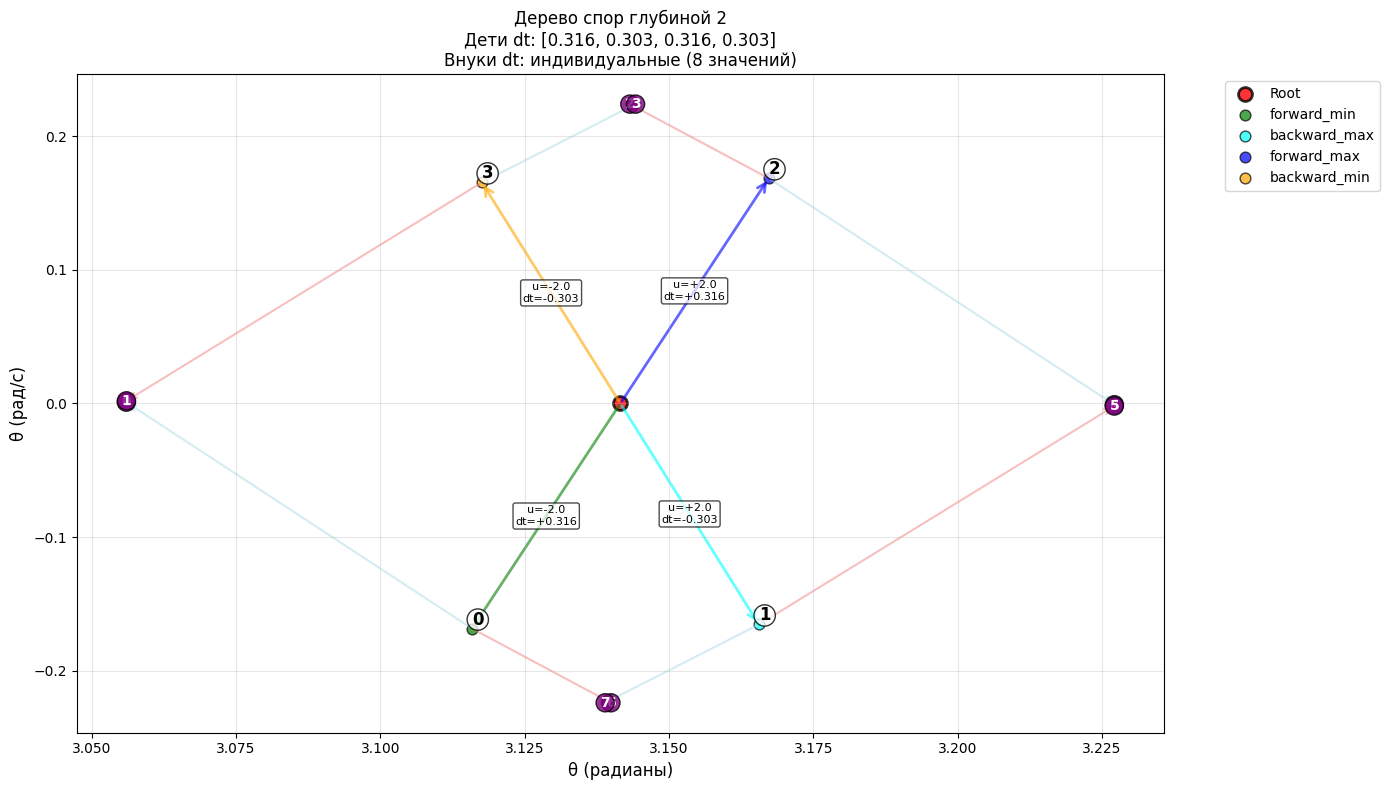


📊 СВОДКА ДЕРЕВА:
   🌳 Корень: [3.14159265 0.        ]
   🍄 Детей: 4 спор
   👶 Внуков: 8 спор
   ⏱️  dt детей: [0.31582446 0.30257196 0.31582443 0.30257199]
   👶 dt внуков: индивидуальные ['1.000', '0.123', '0.138', '1.000', '1.000', '0.123', '0.138', '1.000']


In [ ]:
visualize_tree(result['tree'])

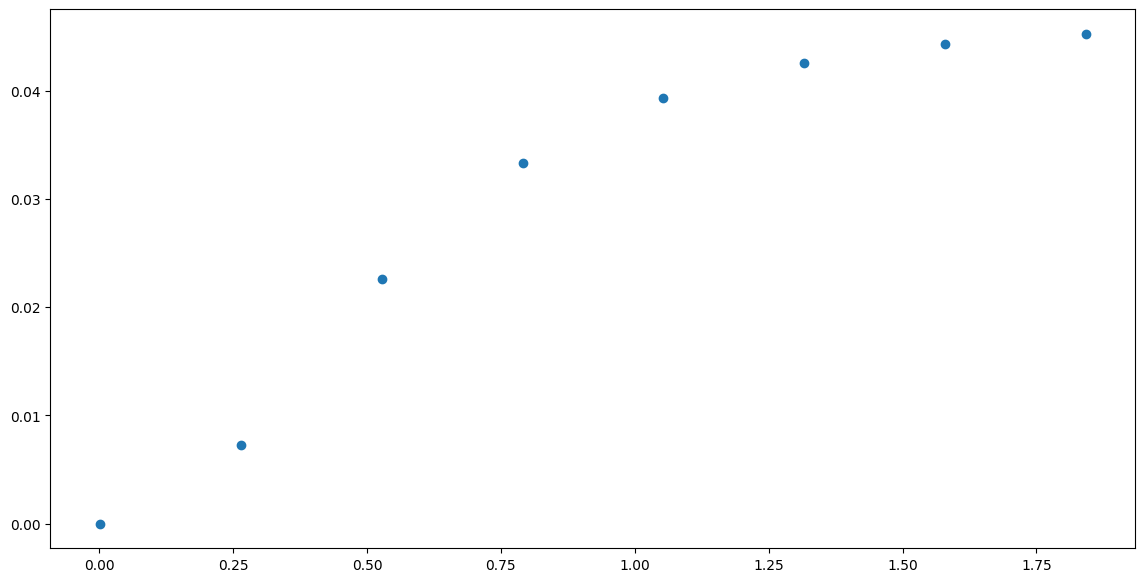

In [125]:
res = [result['final_area'] for result in results]
plt.plot(time_array[:len(res)], res, 'o')